In [204]:
# -----------------------------
# Data manipulation
# -----------------------------
import pandas as pd
import numpy as np
import json
import ast

# -----------------------------
# Plotting
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from io import StringIO

In [205]:
# URL for rank_by_year.csv
url_rank = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-09-09/rank_by_year.csv"

# Fetch CSV via requests (disable SSL verification temporarily)
response = requests.get(url_rank, verify=False)
csv_data = StringIO(response.text)

# Read into pandas DataFrame
rank_by_year = pd.read_csv(csv_data)

# Quick check
print("Rank by Year:")
rank_by_year.head()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Rank by Year:


,code,country,region,rank,visa_free_count,year
0,AF,Afghanistan,ASIA,116,26,2021
1,AF,Afghanistan,ASIA,106,26,2020
2,AF,Afghanistan,ASIA,106,30,2018
3,AF,Afghanistan,ASIA,104,24,2017
4,AF,Afghanistan,ASIA,104,25,2016


In [206]:
max_year = rank_by_year['year'].max()
print(f"Max year in rank_by_year: {max_year}")

# Filter for the latest year
latest_rankings = rank_by_year[rank_by_year['year'] == max_year]
latest_rankings = latest_rankings.sort_values(by='rank')
print(latest_rankings)


Max year in rank_by_year: 2025
     code      country       region  rank  visa_free_count  year
2977   SG    Singapore         ASIA     1              193  2025
3097   KR  South Korea         ASIA     2              190  2025
1669   JP        Japan         ASIA     2              190  2025
3135   ES        Spain       EUROPE     3              189  2025
1249   DE      Germany       EUROPE     3              189  2025
...   ...          ...          ...   ...              ...   ...
3793   YE        Yemen  MIDDLE EAST    95               32  2025
2579   PK     Pakistan         ASIA    95               32  2025
1569   IQ         Iraq  MIDDLE EAST    96               30  2025
3335   SY        Syria  MIDDLE EAST    97               27  2025
19     AF  Afghanistan         ASIA    98               25  2025

[199 rows x 6 columns]


In [207]:
# URL for country_lists.csv
url_country = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-09-09/country_lists.csv"

# Fetch CSV via requests (disable SSL verification temporarily)
response = requests.get(url_country, verify=False)
csv_data = StringIO(response.text)

# Read into pandas DataFrame
country_lists = pd.read_csv(csv_data)

# Quick check
print("Country Lists:")
country_lists.head()

Country Lists:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,code,country,visa_required,visa_online,visa_on_arrival,visa_free_access,electronic_travel_authorisation
0,PS,Palestinian Territory,"[[{""code"":""AF"",""name"":""Afghanistan""},{""code"":""...","[[{""code"":""AG"",""name"":""Antigua and Barbuda""},{...","[[{""code"":""BD"",""name"":""Bangladesh""},{""code"":""B...","[[{""code"":""BO"",""name"":""Bolivia""},{""code"":""CK"",...","[[{""code"":""LK"",""name"":""Sri Lanka""},{""code"":""KE..."
1,AD,Andorra,"[[{""code"":""AF"",""name"":""Afghanistan""},{""code"":""...","[[{""code"":""AO"",""name"":""Angola""},{""code"":""AZ"",""...","[[{""code"":""BH"",""name"":""Bahrain""},{""code"":""BD"",...","[[{""code"":""JP"",""name"":""Japan""},{""code"":""AL"",""n...","[[{""code"":""AU"",""name"":""Australia""},{""code"":""CA..."
2,VA,Vatican City,"[[{""code"":""AF"",""name"":""Afghanistan""},{""code"":""...","[[{""code"":""AZ"",""name"":""Azerbaijan""},{""code"":""B...","[[{""code"":""BH"",""name"":""Bahrain""},{""code"":""BD"",...","[[{""code"":""AL"",""name"":""Albania""},{""code"":""AD"",...","[[{""code"":""AU"",""name"":""Australia""},{""code"":""CA..."
3,SM,San Marino,"[[{""code"":""AF"",""name"":""Afghanistan""},{""code"":""...","[[{""code"":""AZ"",""name"":""Azerbaijan""},{""code"":""B...","[[{""code"":""BH"",""name"":""Bahrain""},{""code"":""BD"",...","[[{""code"":""JP"",""name"":""Japan""},{""code"":""AL"",""n...","[[{""code"":""AU"",""name"":""Australia""},{""code"":""CA..."
4,MC,Monaco,"[[{""code"":""AF"",""name"":""Afghanistan""},{""code"":""...","[[{""code"":""AZ"",""name"":""Azerbaijan""},{""code"":""B...","[[{""code"":""BH"",""name"":""Bahrain""},{""code"":""BD"",...","[[{""code"":""JP"",""name"":""Japan""},{""code"":""AL"",""n...","[[{""code"":""AU"",""name"":""Australia""},{""code"":""CA..."


In [208]:
json_cols = [
    'visa_required',
    'visa_online',
    'visa_on_arrival',
    'visa_free_access',
    'electronic_travel_authorisation'
]

import json

def clean_json_field(text):
    """Convert the messy stringified JSON fields into clean Python lists of dicts."""
    if pd.isna(text):
        return []
    try:
        data = json.loads(text)
        # Many fields are [[{...}]] — unwrap the extra list
        if isinstance(data, list) and len(data) == 1 and isinstance(data[0], list):
            data = data[0]
        return data
    except Exception as e:
        # Optional: print which rows failed to parse
        # print("Error parsing:", text[:80], e)
        return []
    
for col in json_cols:
    country_lists[col] = country_lists[col].apply(clean_json_field)

# Quick check
print("Cleaned Country Lists:")
country_lists.head()


Cleaned Country Lists:


,code,country,visa_required,visa_online,visa_on_arrival,visa_free_access,electronic_travel_authorisation
0,PS,Palestinian Territory,"[{'code': 'AF', 'name': 'Afghanistan'}, {'code...","[{'code': 'AG', 'name': 'Antigua and Barbuda'}...","[{'code': 'BD', 'name': 'Bangladesh'}, {'code'...","[{'code': 'BO', 'name': 'Bolivia'}, {'code': '...","[{'code': 'LK', 'name': 'Sri Lanka'}, {'code':..."
1,AD,Andorra,"[{'code': 'AF', 'name': 'Afghanistan'}, {'code...","[{'code': 'AO', 'name': 'Angola'}, {'code': 'A...","[{'code': 'BH', 'name': 'Bahrain'}, {'code': '...","[{'code': 'JP', 'name': 'Japan'}, {'code': 'AL...","[{'code': 'AU', 'name': 'Australia'}, {'code':..."
2,VA,Vatican City,"[{'code': 'AF', 'name': 'Afghanistan'}, {'code...","[{'code': 'AZ', 'name': 'Azerbaijan'}, {'code'...","[{'code': 'BH', 'name': 'Bahrain'}, {'code': '...","[{'code': 'AL', 'name': 'Albania'}, {'code': '...","[{'code': 'AU', 'name': 'Australia'}, {'code':..."
3,SM,San Marino,"[{'code': 'AF', 'name': 'Afghanistan'}, {'code...","[{'code': 'AZ', 'name': 'Azerbaijan'}, {'code'...","[{'code': 'BH', 'name': 'Bahrain'}, {'code': '...","[{'code': 'JP', 'name': 'Japan'}, {'code': 'AL...","[{'code': 'AU', 'name': 'Australia'}, {'code':..."
4,MC,Monaco,"[{'code': 'AF', 'name': 'Afghanistan'}, {'code...","[{'code': 'AZ', 'name': 'Azerbaijan'}, {'code'...","[{'code': 'BH', 'name': 'Bahrain'}, {'code': '...","[{'code': 'JP', 'name': 'Japan'}, {'code': 'AL...","[{'code': 'AU', 'name': 'Australia'}, {'code':..."


In [209]:
visa_cols = [
    'visa_required',
    'visa_online',
    'visa_on_arrival',
    'visa_free_access',
    'electronic_travel_authorisation'
]

from pandas import json_normalize

flat_frames = []

for col in visa_cols:
    temp = country_lists[['code', 'country', col]].explode(col)
    temp = temp.dropna(subset=[col])
    temp['visa_type'] = col
    temp['to_code'] = temp[col].apply(lambda x: x.get('code') if isinstance(x, dict) else None)
    temp['to_name'] = temp[col].apply(lambda x: x.get('name') if isinstance(x, dict) else None)
    temp = temp.drop(columns=[col])
    flat_frames.append(temp)

# Combine all into one DataFrame
flat_df = pd.concat(flat_frames, ignore_index=True)

# Remove rows missing target country codes
flat_df = flat_df.dropna(subset=['to_code'])

# Drop duplicates if any
flat_df = flat_df.drop_duplicates(subset=['code', 'to_code', 'visa_type']).reset_index(drop=True)

# Optional: rename columns for clarity
flat_df.rename(columns={
    'code': 'from_code',
    'country': 'from_country'
}, inplace=True)


# Quick check
print("Flattened Visa Data:")
flat_df.head()

Flattened Visa Data:


,from_code,from_country,visa_type,to_code,to_name
0,PS,Palestinian Territory,visa_required,AF,Afghanistan
1,PS,Palestinian Territory,visa_required,DZ,Algeria
2,PS,Palestinian Territory,visa_required,AD,Andorra
3,PS,Palestinian Territory,visa_required,AO,Angola
4,PS,Palestinian Territory,visa_required,AI,Anguilla


In [210]:
visa_summary = flat_df.groupby('visa_type').size().reset_index(name='count')
print(visa_summary)


                         visa_type  count
0  electronic_travel_authorisation   1382
1                 visa_free_access  15066
2                  visa_on_arrival   5316
3                      visa_online   5817
4                    visa_required  17392


In [211]:
visa_by_country = (
    flat_df.groupby(['from_country', 'visa_type'])
    .size()
    .reset_index(name='destination_count')
    .sort_values(['from_country', 'visa_type'])
)

visa_pivot = visa_by_country.pivot(
    index='from_country',
    columns='visa_type',
    values='destination_count'
).fillna(0).astype(int)
visa_pivot = visa_pivot.reset_index()
print("Visa Counts by Country:")
visa_pivot.head()

Visa Counts by Country:


visa_type,from_country,electronic_travel_authorisation,visa_free_access,visa_on_arrival,visa_online,visa_required
0,Afghanistan,3,6,16,43,158
1,Albania,6,88,29,29,74
2,Algeria,2,26,27,39,132
3,Andorra,16,120,35,23,32
4,Angola,2,26,20,37,141


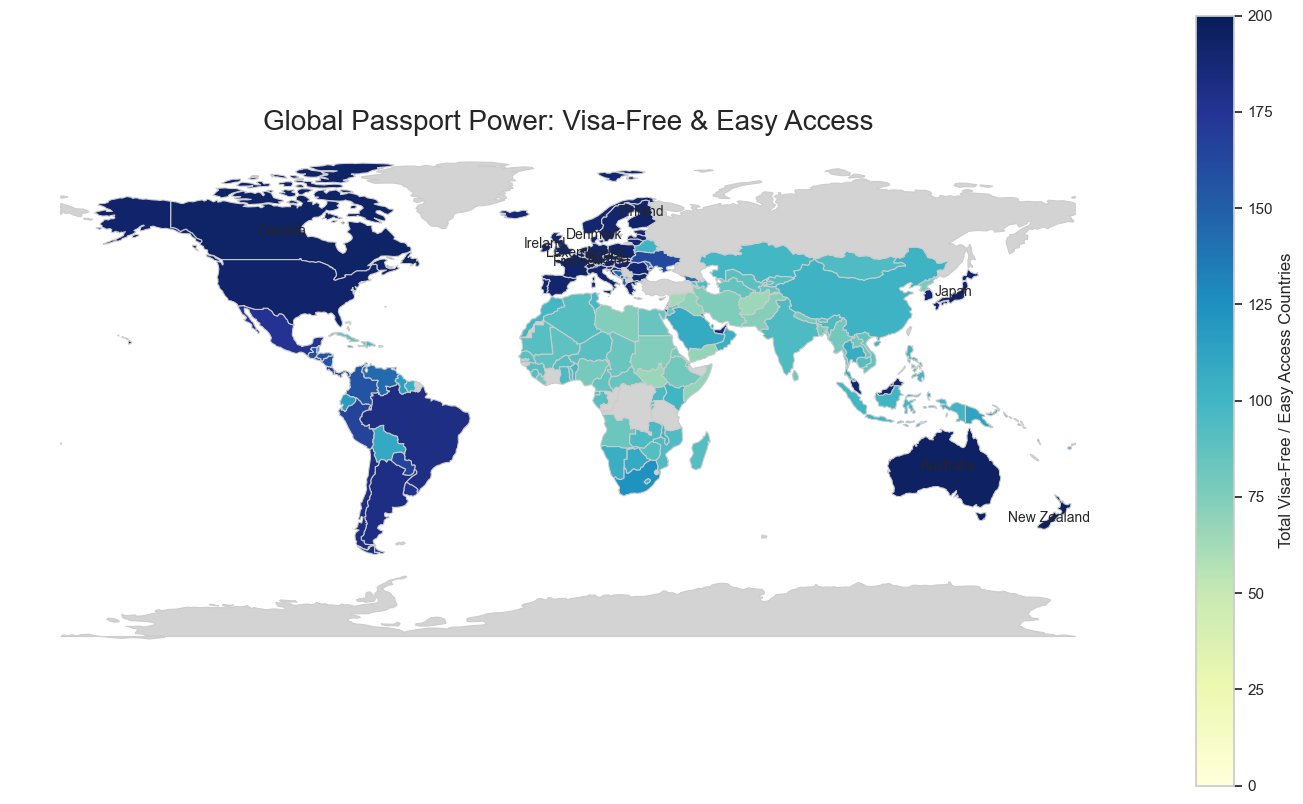

In [212]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Load the Natural Earth low-resolution world map
world = gpd.read_file("https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json")

# Example: total visa-free access
visa_pivot['total_visa_free'] = visa_pivot['visa_free_access'] + visa_pivot['visa_on_arrival'] + visa_pivot['visa_online']

# Fix country name mismatches
name_corrections = {
    "United States": "United States of America",
    "Russia": "Russian Federation",
    "Vatican City": "Vatican",
    "Palestinian Territory": "Palestine",
    "Czechia": "Czech Republic",
    # add more if needed
}
visa_pivot['from_country'] = visa_pivot['from_country'].replace(name_corrections)

# Merge world map with visa data
world_visa = world.merge(visa_pivot, how='left', left_on='name', right_on='from_country')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(18, 10))

world_visa.plot(
    column='total_visa_free',            # metric to color
    cmap='YlGnBu',                        # color palette
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Total Visa-Free / Easy Access Countries"},
    missing_kwds={"color": "lightgrey"},  # grey for missing countries
    vmin=0,
    vmax=200
)

# Annotate top 10 countries
for idx, row in world_visa.nlargest(10, 'total_visa_free').iterrows():
    geom = row['geometry']
    # Get centroid of the largest polygon if MultiPolygon
    if geom.geom_type == 'MultiPolygon':
        largest_poly = max(geom.geoms, key=lambda a: a.area)
        centroid = largest_poly.centroid
    else:  # Polygon
        centroid = geom.centroid
    ax.text(centroid.x, centroid.y, row['from_country'], fontsize=10, ha='center')

# Title and remove axis
ax.set_title("Global Passport Power: Visa-Free & Easy Access", fontsize=20)
ax.set_axis_off()

plt.show()



